# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import json
from statsmodels.formula.api import ols
from statsmodels.iolib.smpickle import load_pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene
from matplotlib.pyplot import figure

plt.style.use('seaborn');
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 300
sns.set_context("talk")
figure(figsize=(8, 6), dpi=300);
sns.set_style("whitegrid")
sns.set_palette("tab10")

<Figure size 2400x1800 with 0 Axes>

# Load data

## Empirical data

In [38]:
# Directory where empirical data is
datadir = "../experiments/experiment3/data/cleaned_data.json"
# Read empirical data into dataframe
data = pd.read_json(datadir)

In [39]:
# Compute mean rt values
df = data.groupby('scene').rt.apply(np.mean)
data['avg_rt'] = np.nan
for avg_rt,scene in zip(df,df.index):
    data.loc[data['scene']==scene,'avg_rt'] = avg_rt

In [40]:
data

,trial_index,subject_id,exp_condition,rt,response_,task,correct_response,correct,task_condition,scene,...,trial_condition,response,participant_accuracy,trial_accuracy,scene_accuracy,sim_time,collision,straight_path,3,avg_rt
0,0,61716480d6da1714ff60ed0d,j,884,f,response,f,True,No,low_nocol_yessp_1,...,No,No,0.895833,0.765957,0.936170,low,nocol,yessp,1.mp4,863.956522
1,1,61716480d6da1714ff60ed0d,j,726,f,response,j,False,Yes,low_yescol_yessp_2,...,Yes,No,0.895833,0.702128,0.872340,low,yescol,yessp,2.mp4,824.652174
2,2,61716480d6da1714ff60ed0d,j,885,f,response,f,True,No,low_nocol_nosp_2,...,No,No,0.895833,0.914894,0.893617,low,nocol,nosp,2.mp4,936.723404
3,3,61716480d6da1714ff60ed0d,j,981,f,response,f,True,No,med_nocol_nosp_3,...,No,No,0.895833,0.787234,0.914894,med,nocol,nosp,3.mp4,1326.555556
4,4,61716480d6da1714ff60ed0d,j,1189,j,response,j,True,Yes,high_yescol_yessp_2,...,Yes,Yes,0.895833,0.893617,1.000000,high,yescol,yessp,2.mp4,1102.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,43,5f145461435271023220d6ac,j,1551,f,response,f,True,No,med_nocol_nosp_1,...,No,No,0.916667,0.872340,0.936170,med,nocol,nosp,1.mp4,1544.200000
2252,44,5f145461435271023220d6ac,j,1231,f,response,f,True,No,high_nocol_nosp_1,...,No,No,0.916667,0.914894,0.936170,high,nocol,nosp,1.mp4,1332.391304
2253,45,5f145461435271023220d6ac,j,791,f,response,f,True,No,med_nocol_nosp_2,...,No,No,0.916667,0.893617,0.957447,med,nocol,nosp,2.mp4,1092.234043
2254,46,5f145461435271023220d6ac,j,804,f,response,f,True,No,low_nocol_nosp_4,...,No,No,0.916667,0.829787,0.829787,low,nocol,nosp,4.mp4,1094.847826


In [5]:
# data["is_col"] = data["collision"].replace({"yescol": 1, "nocol": 0})

In [6]:
# df["task_condition"].replace({"Yes": 1, "No": 0})

KeyError: 'task_condition'

In [ ]:
# col = data.groupby('scene').mean()
# df = data[['scene','task_condition','scene_accuracy']]
# df["task_condition"] = df["task_condition"].replace({"Yes": 1, "No": 0})
# tst = df.groupby('scene')[['task_condition','scene_accuracy']].describe()

## Ground-truth simulation time data

In [41]:
# Ground-truth simulation-time values for each scene
sim_vals = pd.read_json("../data/model/pilot3/simulation_vals.json")
# Rename the columns so we can index by 'scene'
sim_vals = sim_vals.rename(columns={'name':'scene'})
print(sim_vals.columns)
# Select only the scene and ticks columns
sim_vals = sim_vals[['scene','ticks']]
# Calculate the tick mean
sim_vals['tick_mean'] = sim_vals.ticks.apply(lambda x: np.mean(x))

Index(['scene', 'ticks', 'tick_mean'], dtype='object')


In [42]:
# Put it all into one dataframe
data = data.merge(sim_vals, on='scene')

## Model data

In [43]:
# Dataframe for model data
split = pd.DataFrame()
# Read in model data
models = pd.read_json("../data/model/pilot3/models.json")
# Gather each model
for m in ['abstraction', 'deterministic']:
    split = pd.concat([split, pd.DataFrame(models[m].tolist(),columns=[f'{m}_collision_prob',
                                                                       f'{m}_samples',
                                                                       f'{m}_ticks'])],axis=1)
# Concatenate all of the models together into one dataframe
models = pd.concat([models['name'], split],axis=1)
# Rename columns so we can index by scenes
models = models.rename(columns={'name':'scene'});
# Compute stats over ticks
for m in ['abstraction','deterministic']:
    models[f'{m}_tick_mean'] = models[f'{m}_ticks'].apply(np.mean)

In [44]:
# Put it all into one dataframe
data = data.merge(models, on='scene')

## Model fits

In [45]:
# Directory with model fits
modeldir = "../data/model_fits/"

In [46]:
# Go through pickled models and find the best one
model_files = [m for m in os.listdir(modeldir) if m.endswith('.pickle')]
# Empty list for models
models = []
# Append all models to the list
for m in model_files:
    models.append((load_pickle(modeldir+m),m))
# Find the best model by rsquared
best_m = None
for m in models:
    if best_m:
        if m[0].rsquared > best_m[0].rsquared:
            best_m = m
    else:
        best_m = m

In [47]:
# Best model
best_m[0].mse_model

1685144.784307674

In [48]:
x = []
y = []
mse = []
cor = []
for m in models:
    s = m[1].split('_')
    x.append(int(s[2].split('n')[1]))
    y.append(int(s[4].split('d')[1]))
    mse.append(m[0].mse_model)
    cor.append(m[0].rsquared)

In [49]:
df = pd.DataFrame({'N':x,'D':y,'mse':mse,'cor':cor})
mse_pivot = df.pivot(index='N', columns='D', values='mse')
cor_pivot = df.pivot(index='N', columns='D', values='cor')

Text(0.5, 77.66666666666667, 'D: Length of path projection')

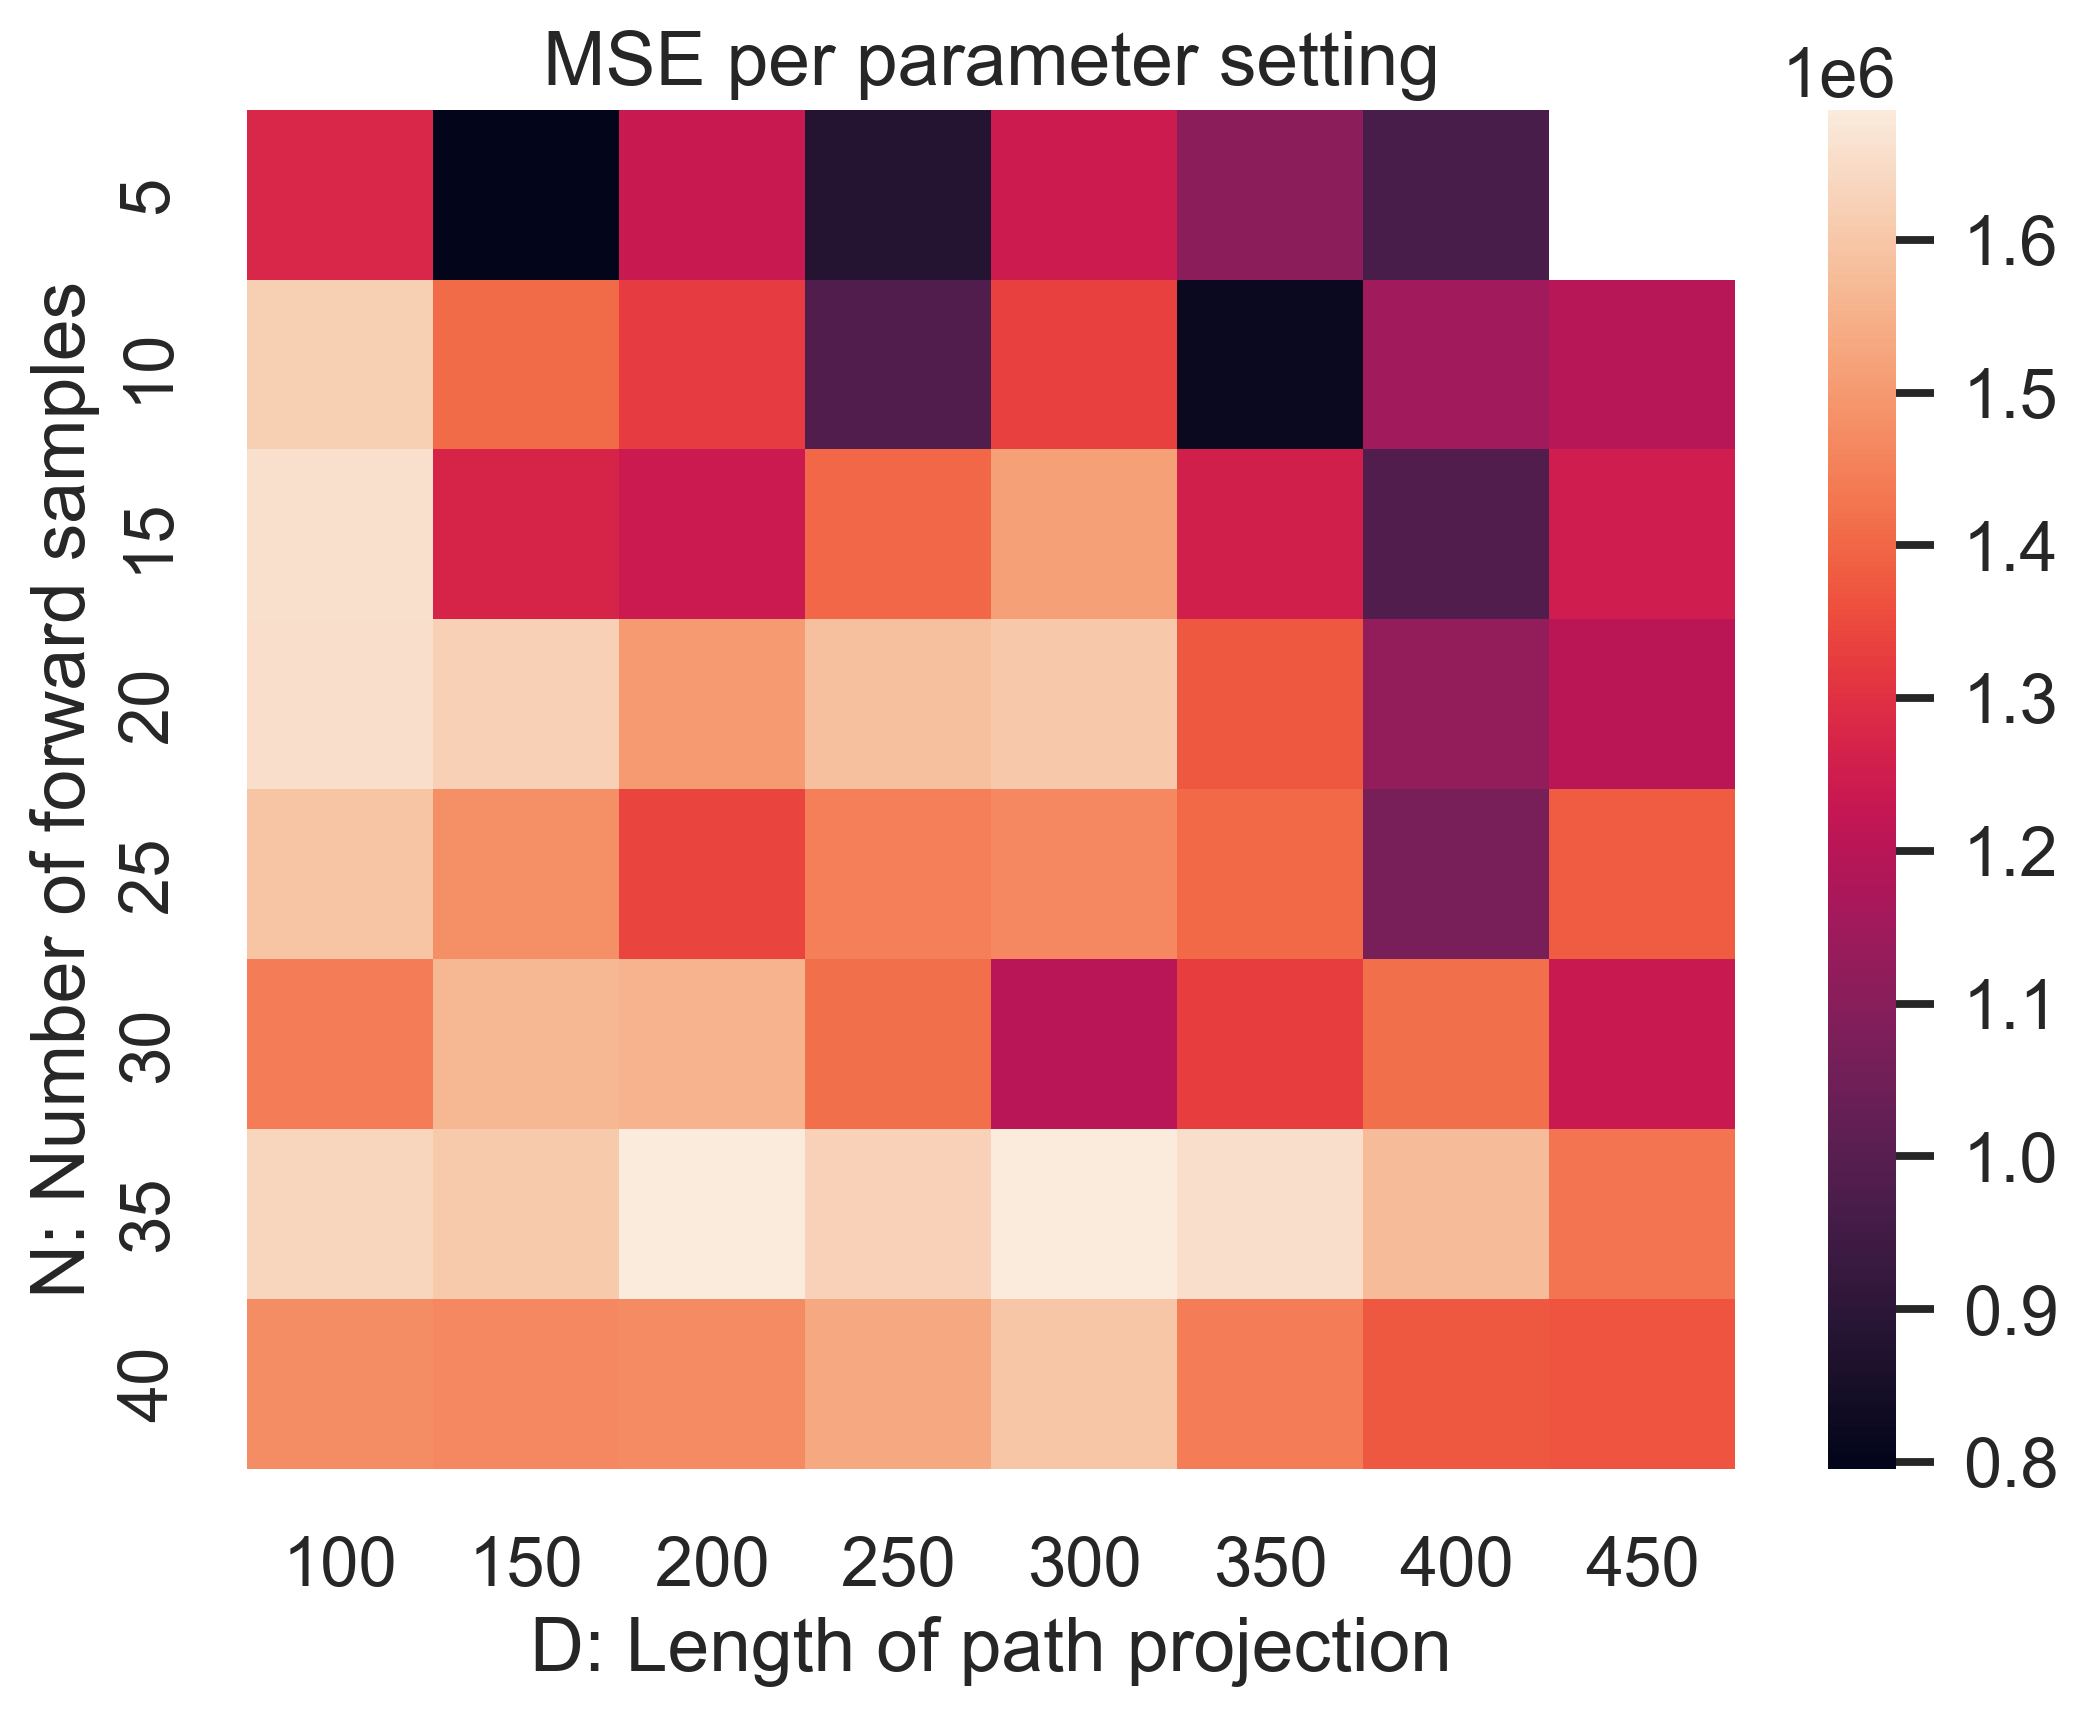

In [50]:
sns.heatmap(mse_pivot)
plt.title("MSE per parameter setting")
plt.ylabel("N: Number of forward samples")
plt.xlabel("D: Length of path projection")

Text(0.5, 77.66666666666667, 'D: Length of path projection')

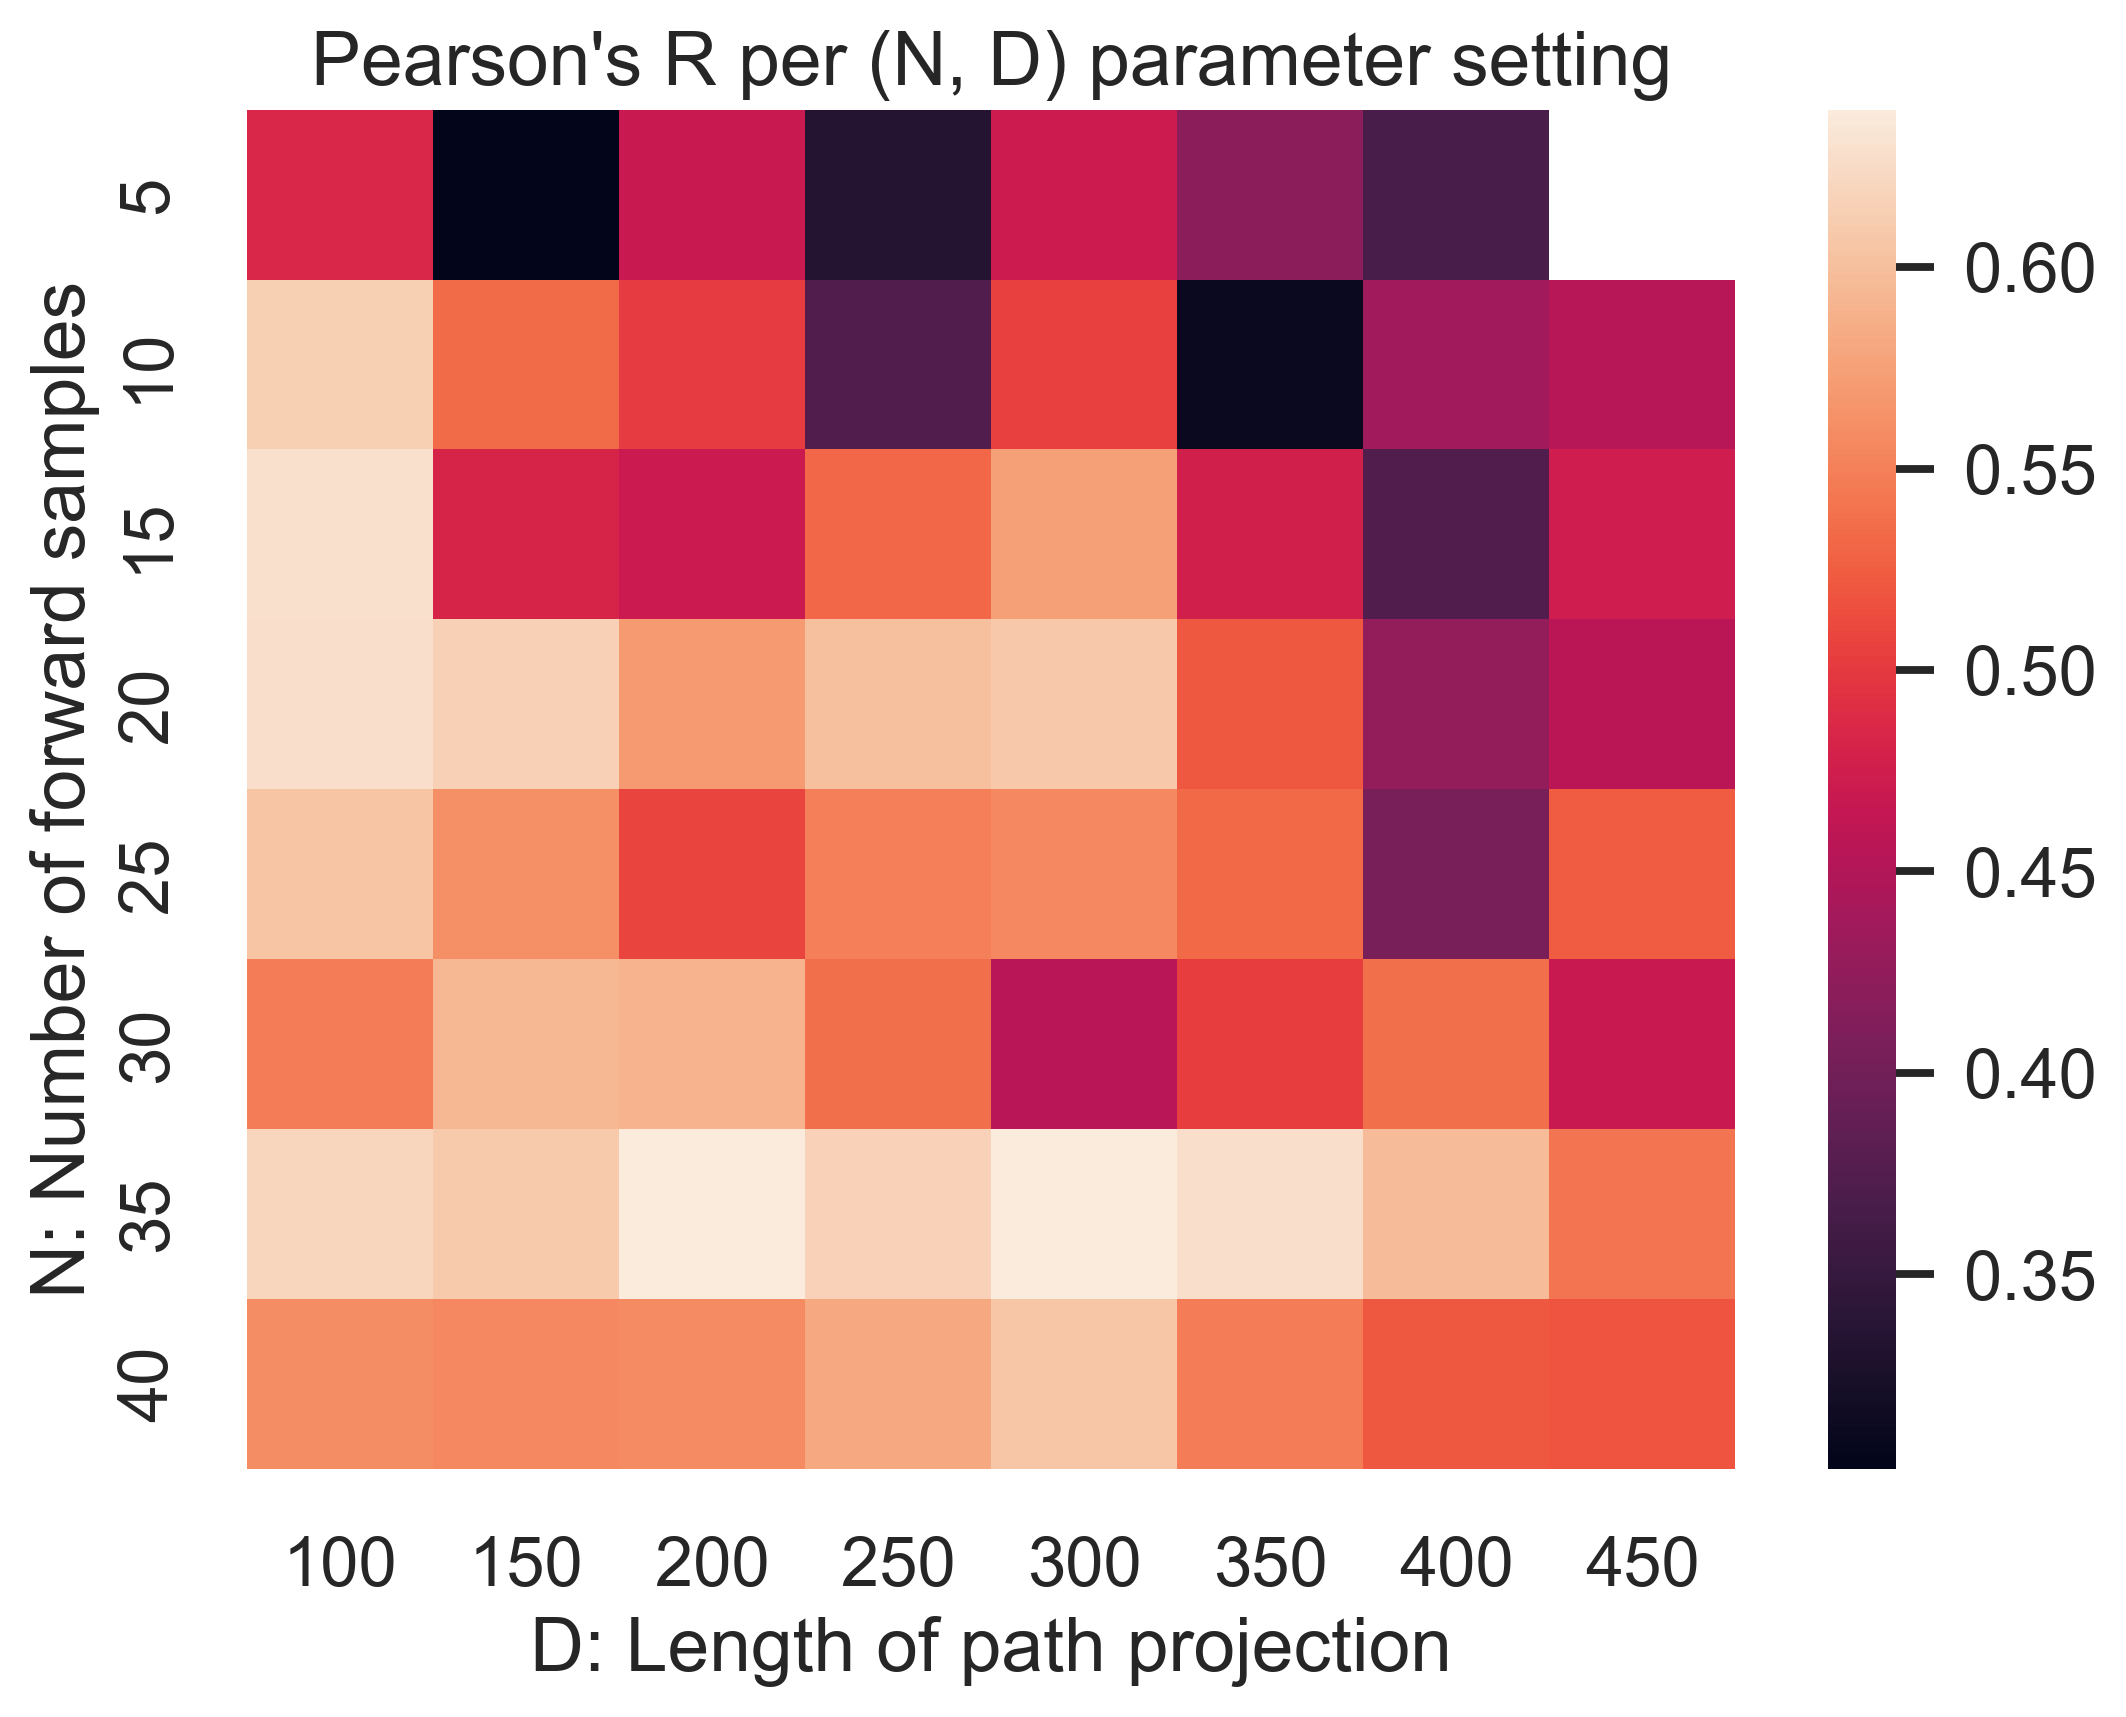

In [51]:
sns.heatmap(cor_pivot)
plt.title("Pearson's R per (N, D) parameter setting")
plt.ylabel("N: Number of forward samples")
plt.xlabel("D: Length of path projection")

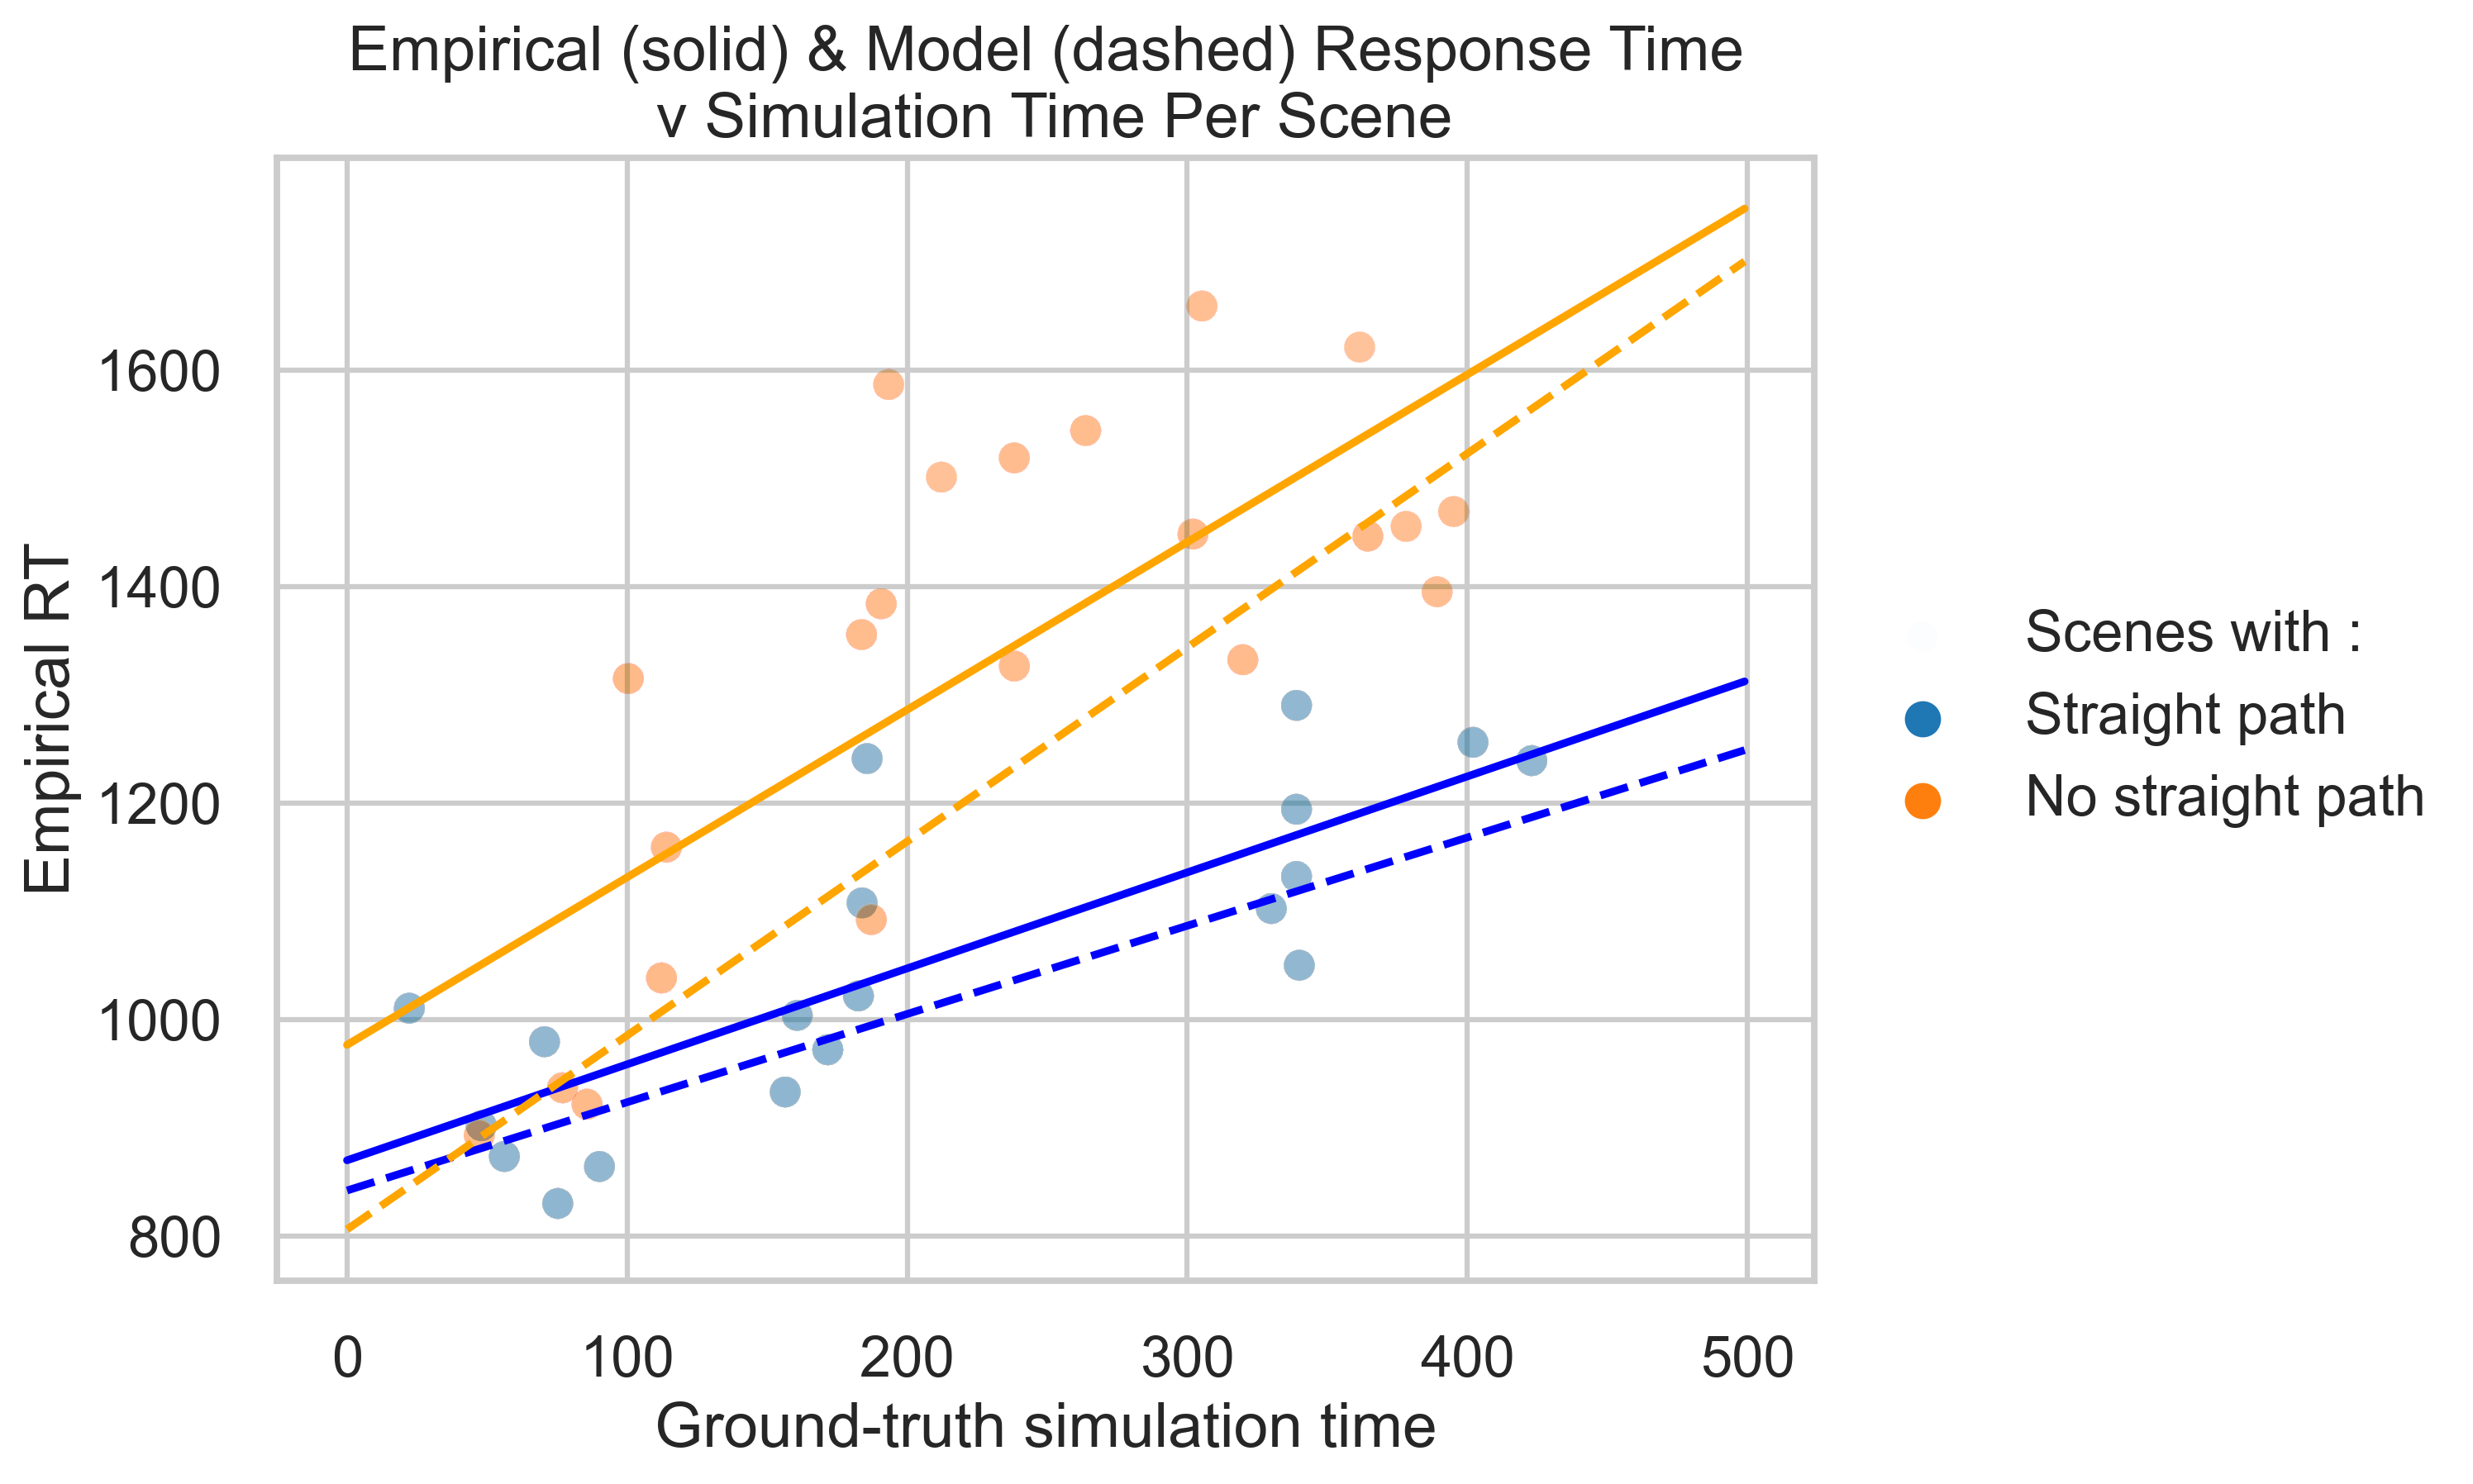

In [95]:
# Formula for empirical data to ground-truth
formula1 = 'avg_rt ~ tick_mean'
# Formulat for empirical data to model
formula2 = 'abstraction_tick_mean ~ tick_mean'

# Ordinary linear models based on path condition for empirical data
empirical_sp = ols(formula1, data[data.straight_path == 'yessp']).fit()
empirical_nosp = ols(formula1, data[data.straight_path == 'nosp']).fit()
# Ordinary linear models based on path condition for model
model_sp = ols(formula2, data[data.straight_path == 'yessp']).fit()
model_nosp = ols(formula2, data[data.straight_path == 'nosp']).fit()

# Parameters from both models
p1 = empirical_sp.params
q1 = empirical_nosp.params
p2 = model_sp.params
q2 = model_nosp.params

# x-values for regression lines
x = np.arange(0, 500)
# Scatterplot
ax = sns.scatterplot(x='tick_mean', y='avg_rt', hue='straight_path',data=data,alpha= 0.01)

# Plot regression lines on the same axis object
ax.plot(x, p1.Intercept + p1.tick_mean * x,label='straight path',color='blue')
ax.plot(x, q1.Intercept + q1.tick_mean * x,label='no straight path',color="orange")

ax.plot(x, p2.Intercept + 757.203079 + p2.tick_mean * x * 2.119, linestyle='dashed',label='straight path',color='blue')
ax.plot(x, q2.Intercept + 757.203079 + q2.tick_mean * x * 2.119, linestyle='dashed',label='no straight path',color='orange')

plt.title("Empirical (solid) & Model (dashed) Response Time\n v Simulation Time Per Scene")
plt.ylabel("Empirical RT")
plt.xlabel("Ground-truth simulation time");
plt.legend(labels=["Scenes with :","Straight path",
                  "No straight path"],
          loc=6,
          bbox_to_anchor=(1, 0., 1, 1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


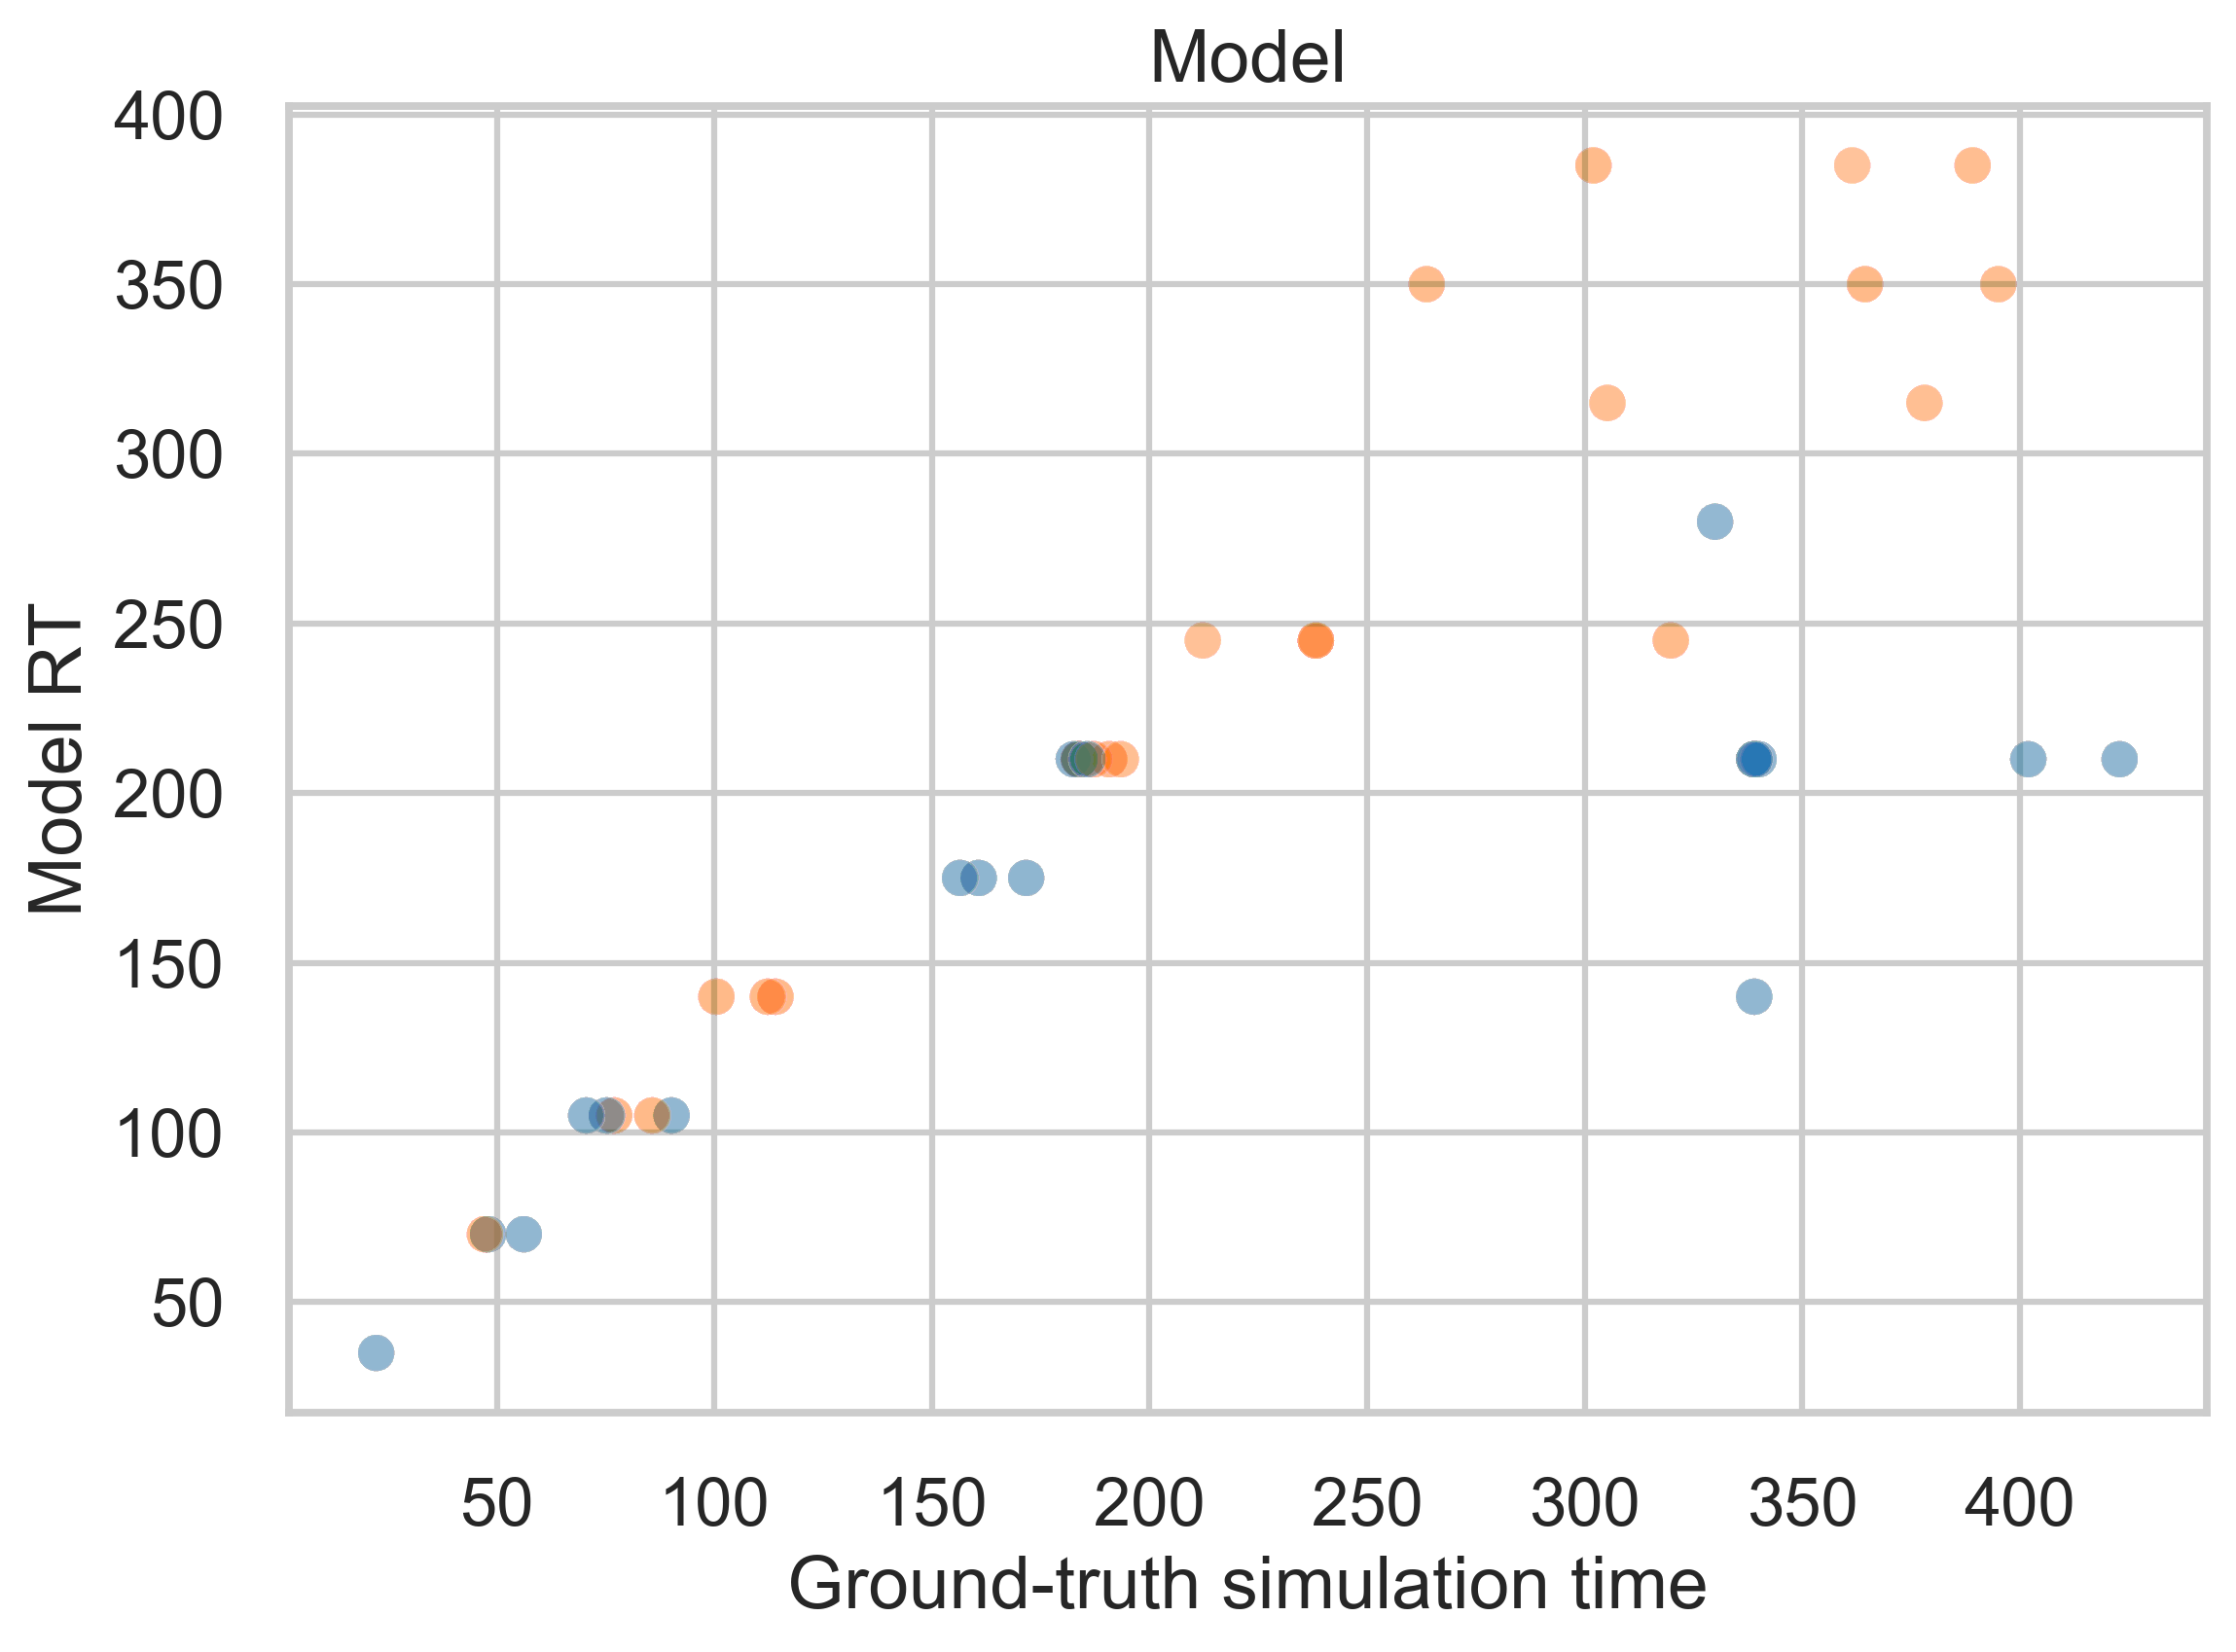

In [91]:
# Scatterplot
ax = sns.scatterplot(x='tick_mean', y='abstraction_tick_mean', hue='straight_path',data=data,alpha= 0.01, legend=False)

plt.title("Model")
plt.ylabel("Model RT")
plt.xlabel("Ground-truth simulation time");
plt.legend()
plt.tight_layout()

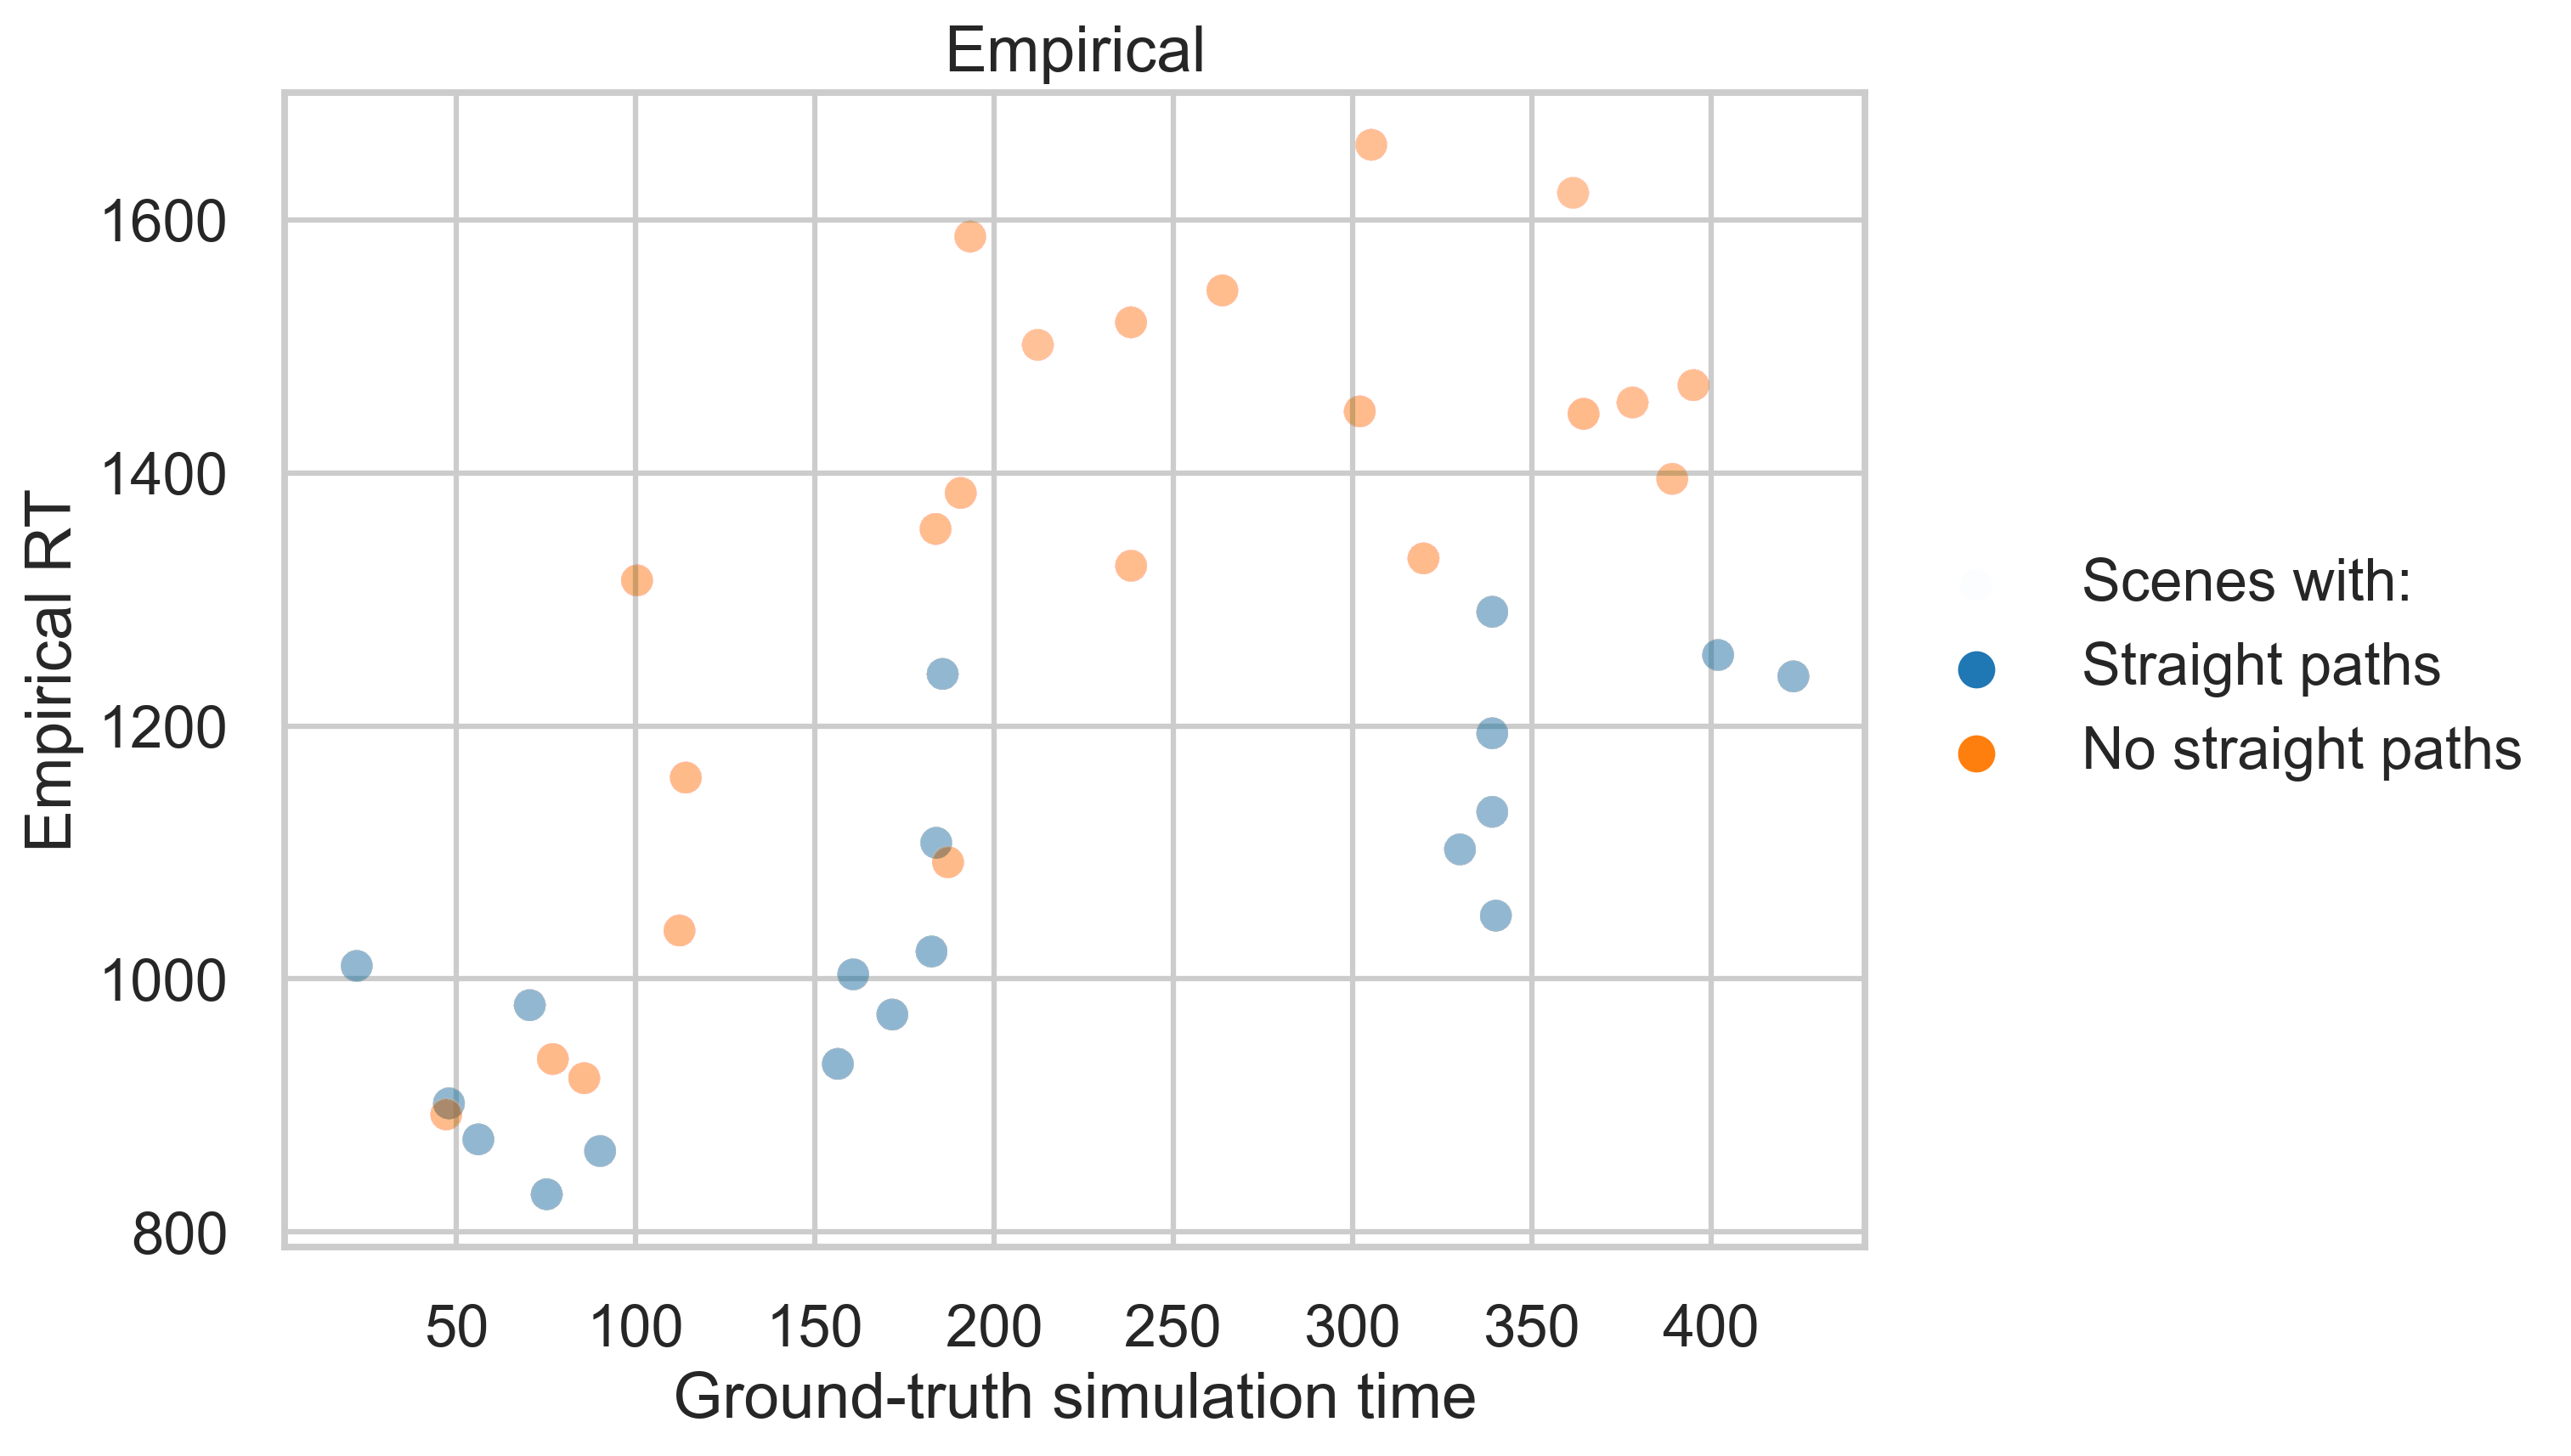

In [88]:
# Scatterplot
ax = sns.scatterplot(x='tick_mean', y='avg_rt', hue='straight_path',data=data,alpha= 0.01)

plt.title("Empirical")
plt.ylabel("Empirical RT")
plt.xlabel("Ground-truth simulation time");
plt.legend(labels=["Scenes with:",
                   "Straight paths",
                   "No straight paths"
                   ],
          loc=6,
          bbox_to_anchor=(1, 0., 1, 1))

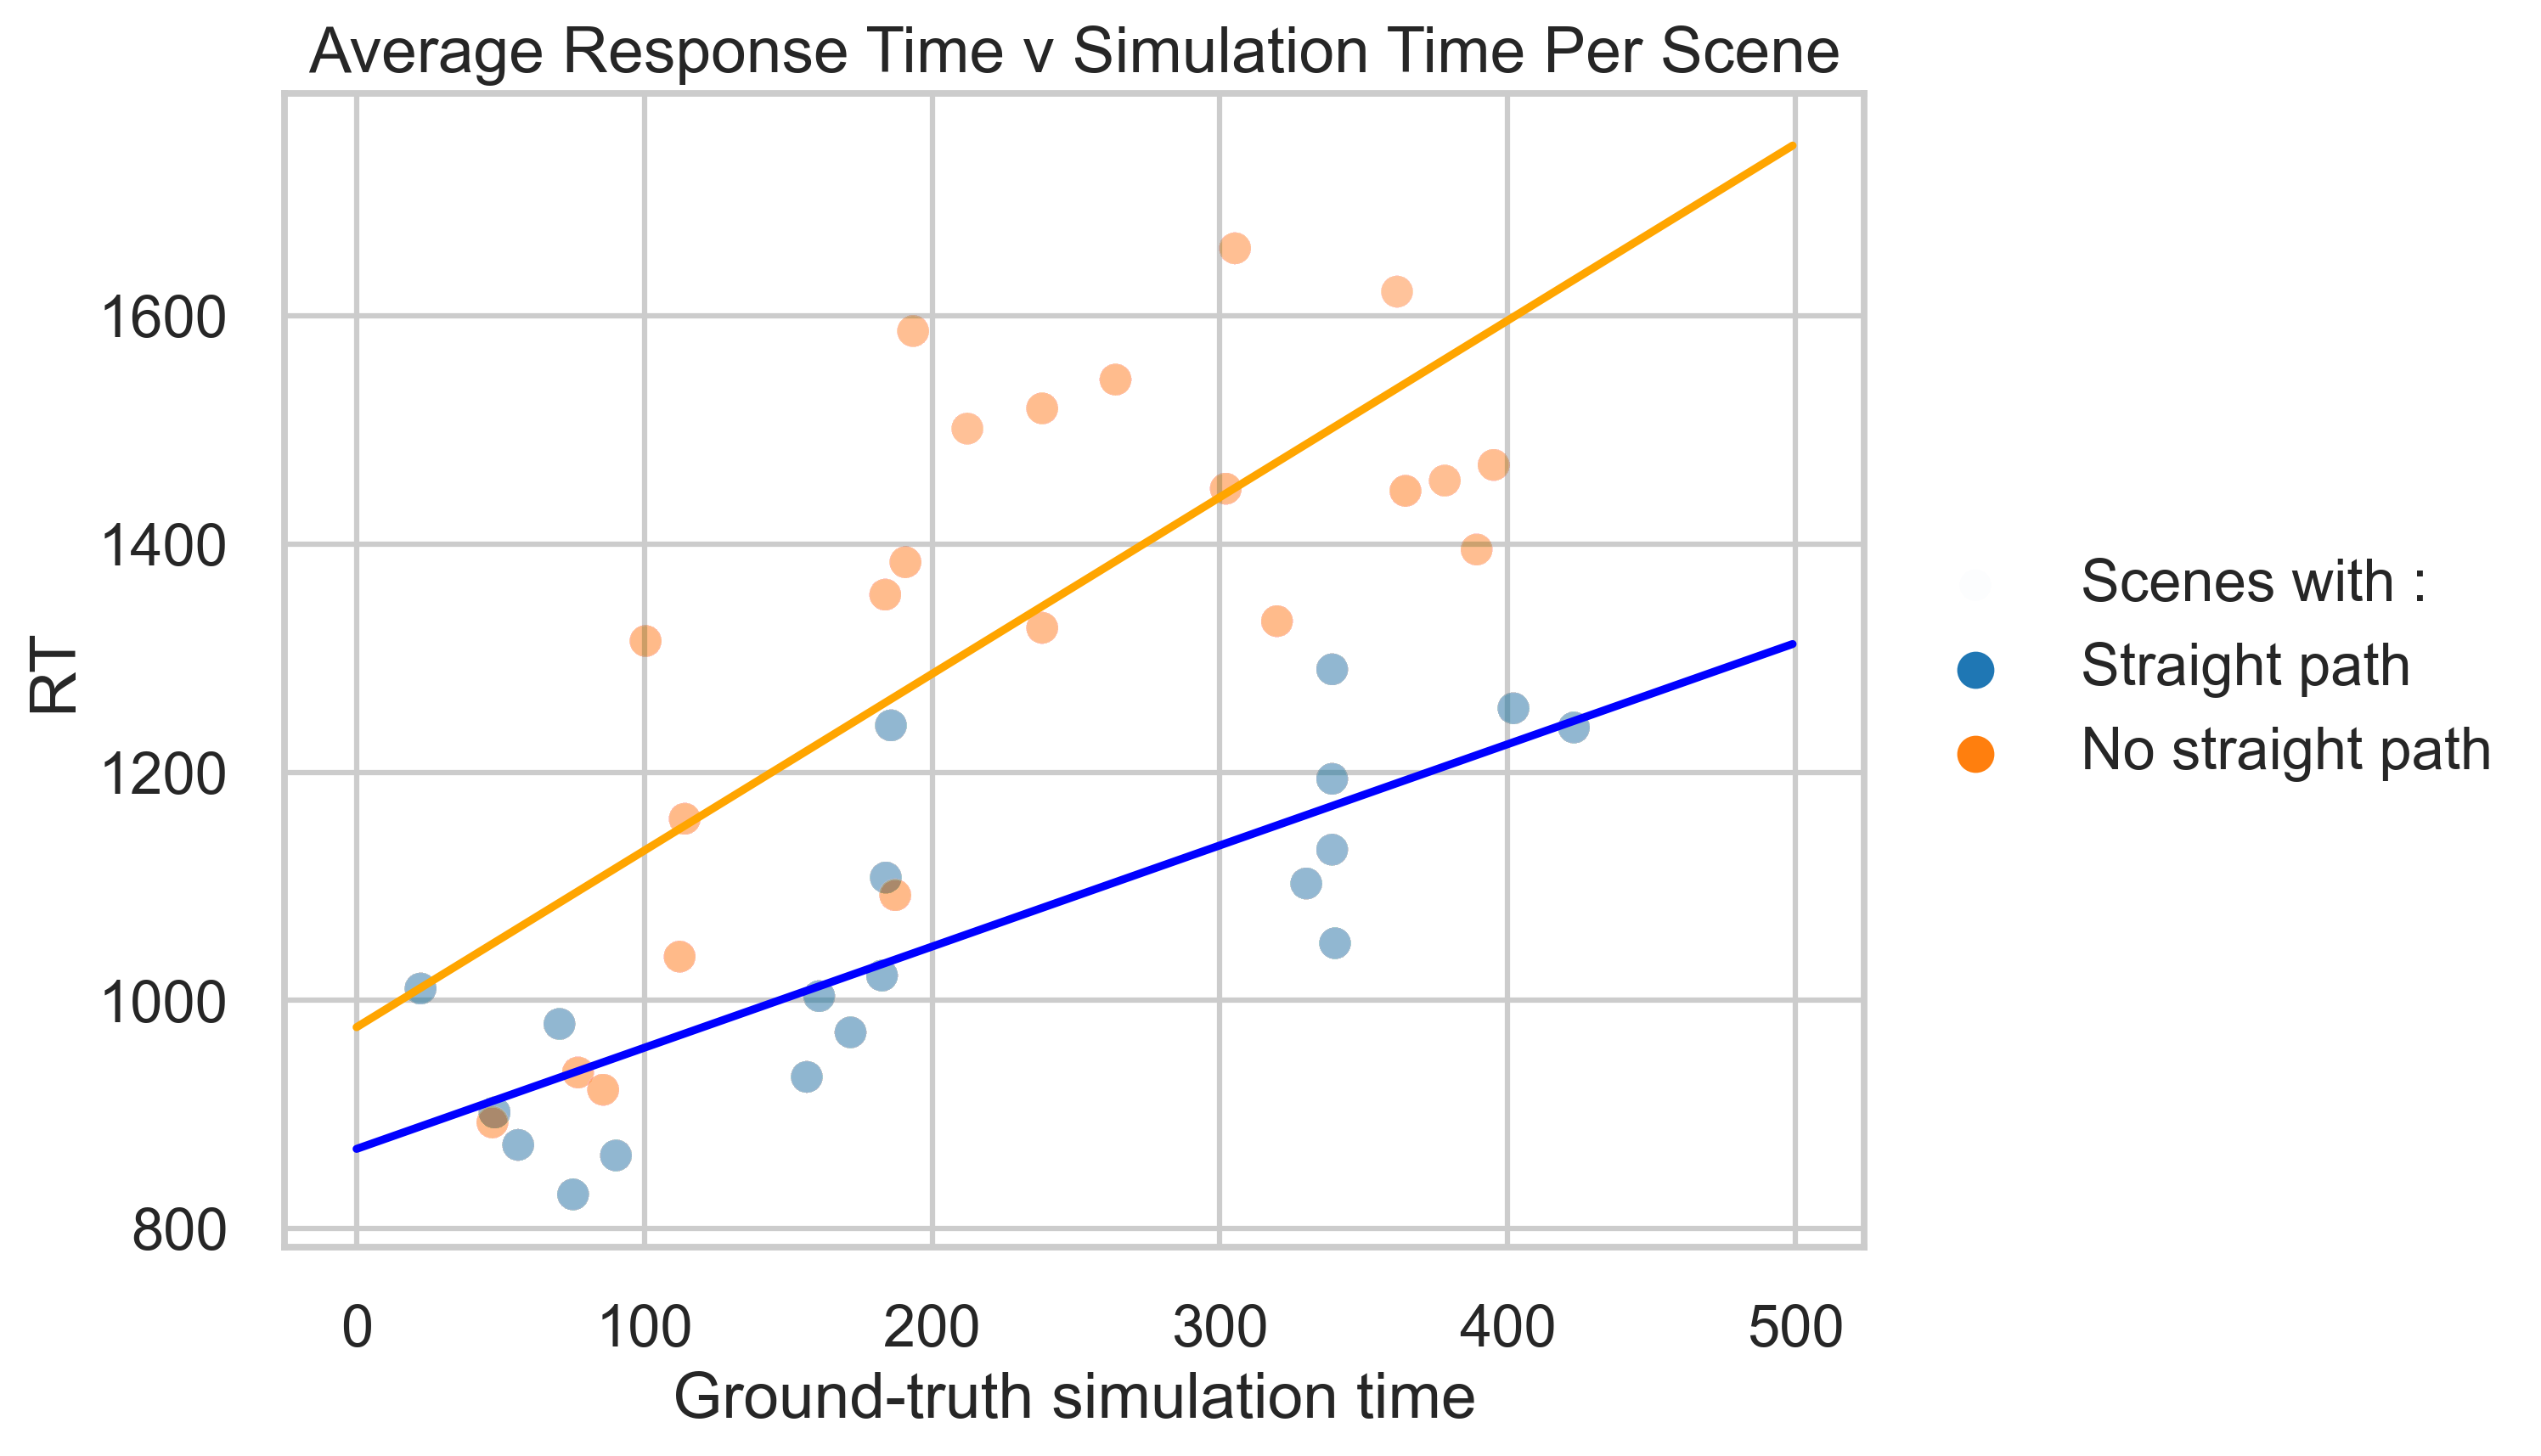

In [54]:
# Formula for empirical data to ground-truth
formula1 = 'avg_rt ~ tick_mean'
# Formulat for empirical data to model
formula2 = 'abstraction_tick_mean ~ tick_mean'

# Ordinary linear models based on path condition for empirical data
empirical_sp = ols(formula1, data[data.straight_path == 'yessp']).fit()
empirical_nosp = ols(formula1, data[data.straight_path == 'nosp']).fit()

# Parameters from both models
p1 = empirical_sp.params
q1 = empirical_nosp.params
p2 = model_sp.params
q2 = model_nosp.params

# x-values for regression lines
x = np.arange(0, 500)
# Scatterplot
ax = sns.scatterplot(x='tick_mean', y='avg_rt', hue='straight_path',data=data,alpha= 0.01)

# Plot regression lines on the same axis object
ax.plot(x, p1.Intercept + p1.tick_mean * x,label='straight path',color='blue')
ax.plot(x, q1.Intercept + q1.tick_mean * x,label='no straight path',color="orange")

plt.title("Average Response Time v Simulation Time Per Scene")
plt.ylabel("RT")
plt.xlabel("Ground-truth simulation time");
plt.legend(labels=["Scenes with :","Straight path",
                  "No straight path"],
          loc=6,
          bbox_to_anchor=(1, 0., 1, 1))

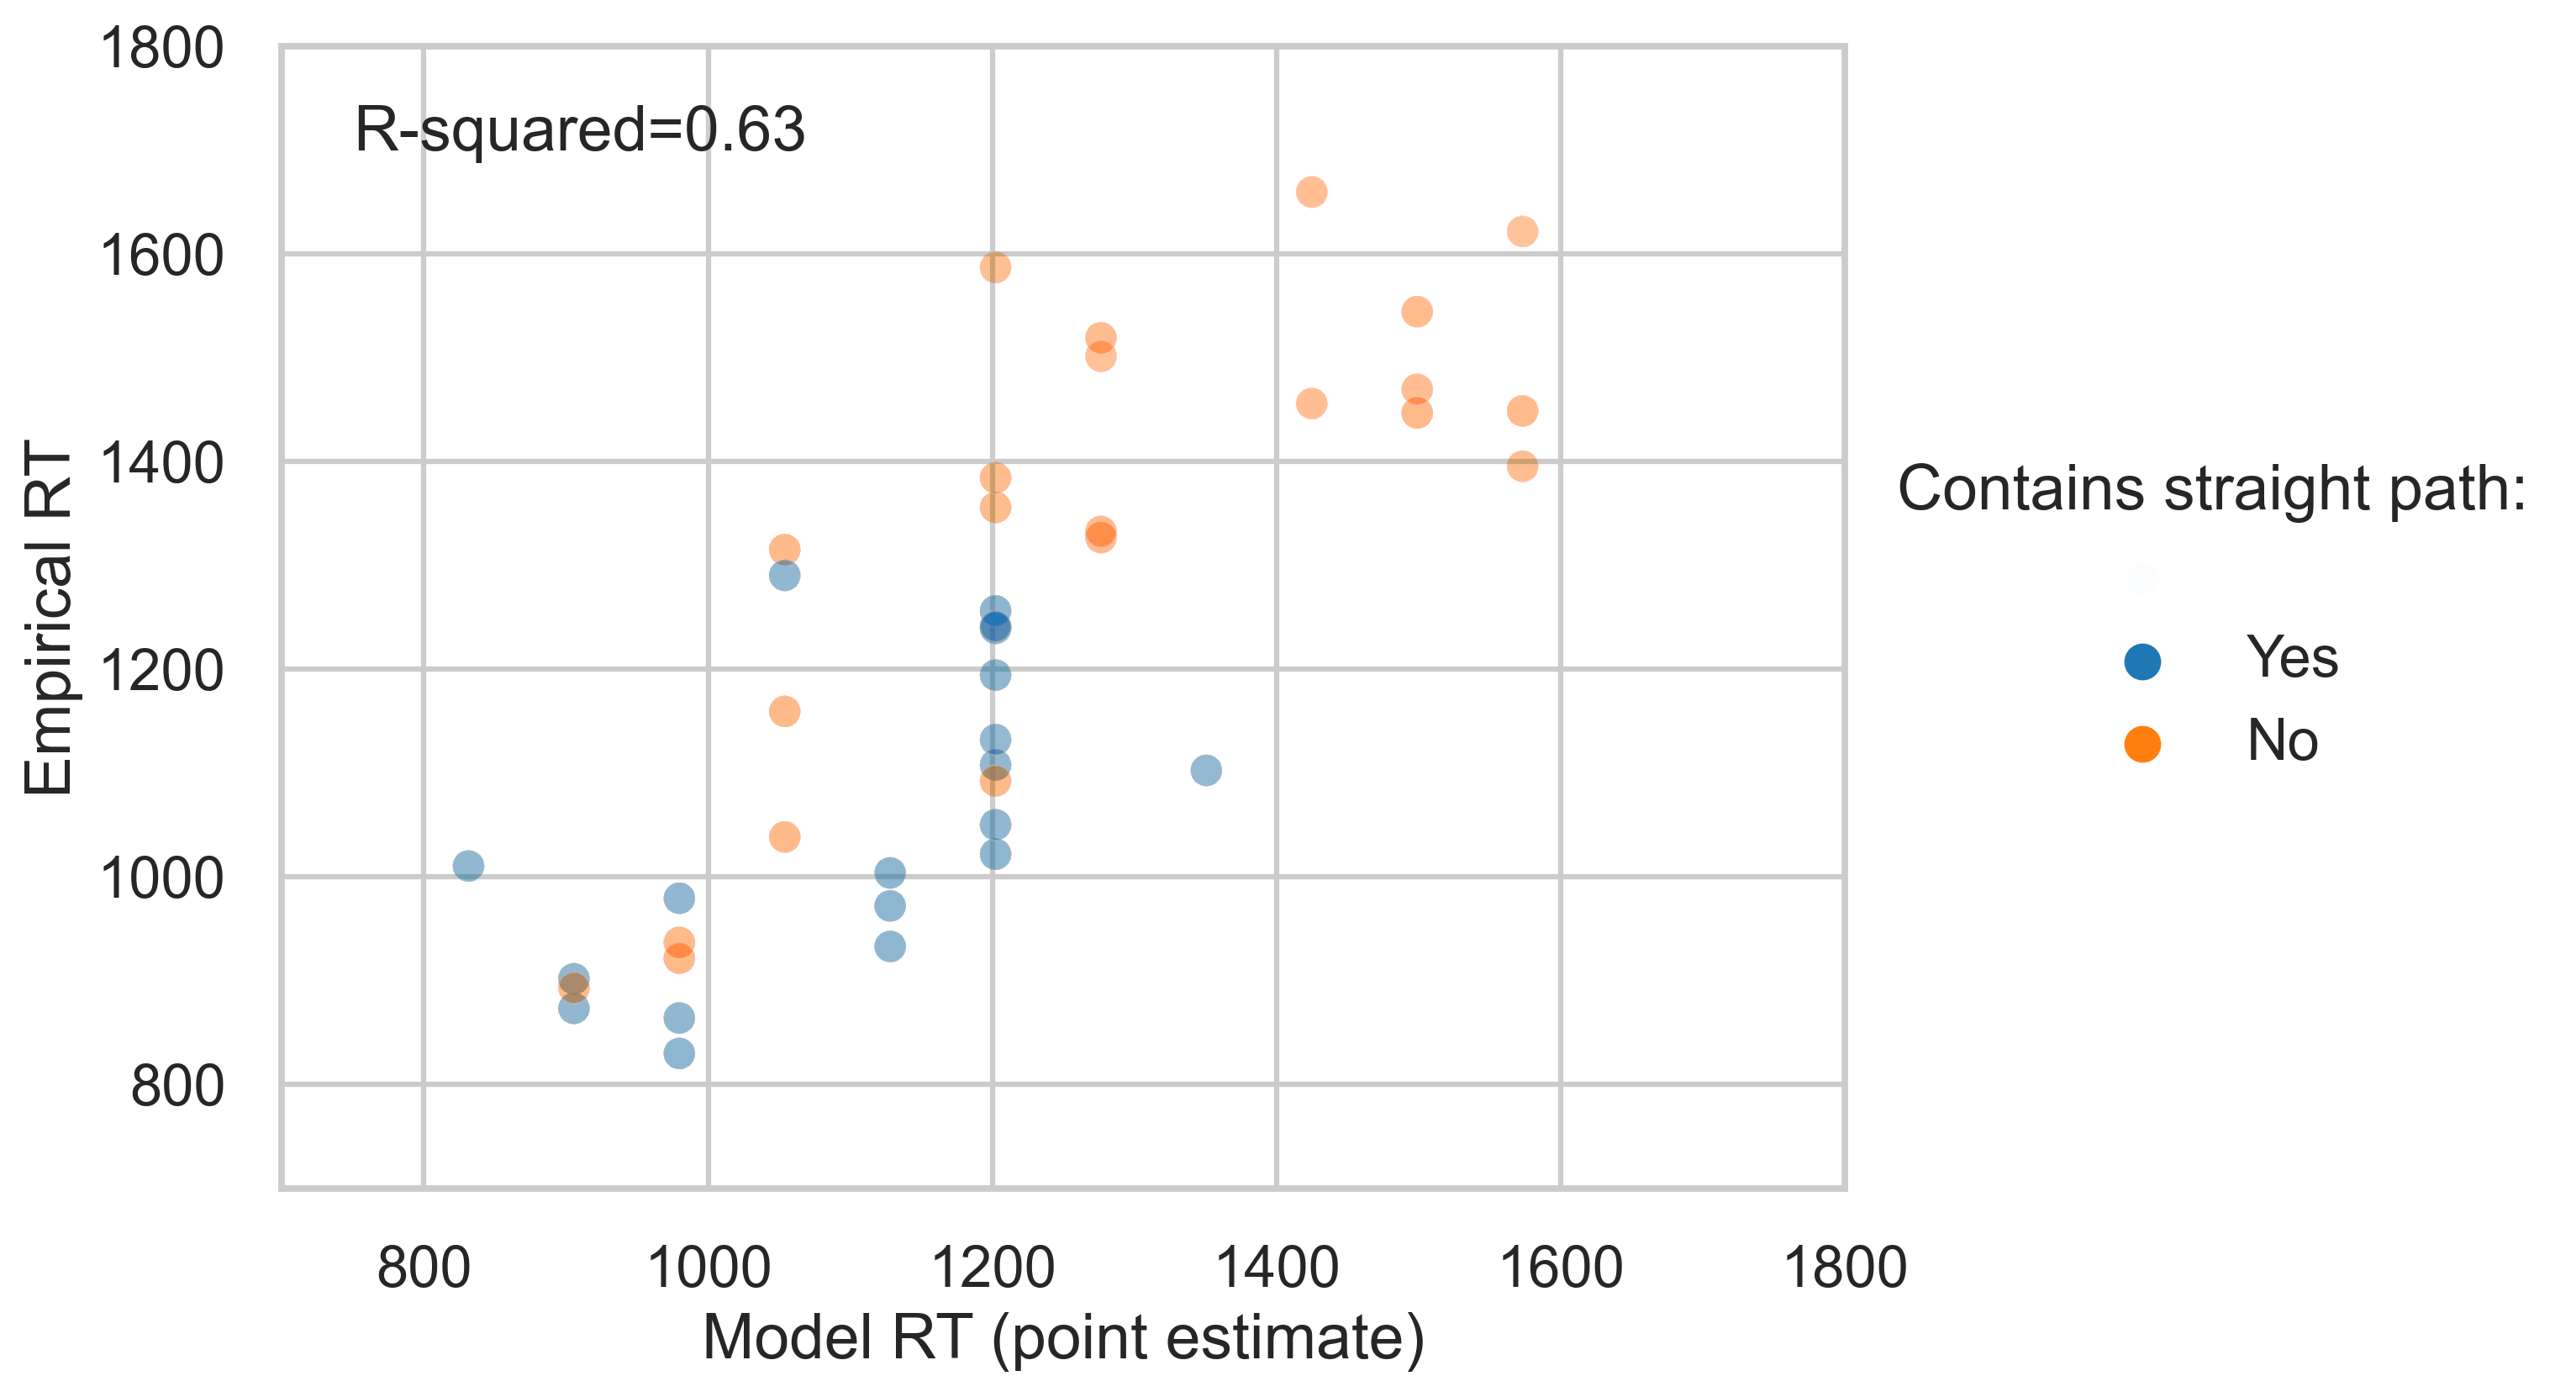

In [53]:
# Parameters from both models
p1 = empirical_sp.params
q1 = empirical_nosp.params
p2 = model_sp.params
q2 = model_nosp.params

df = data
df['abstraction_fit'] = df.abstraction_tick_mean.apply(lambda x: x*best_m[0].params.y_pred + best_m[0].params.Intercept)

ax = sns.scatterplot(x='abstraction_fit', y='avg_rt', hue='straight_path',data=df,alpha= 0.01)
ax.set(ylim=(700,1800),xlim=(700,1800))
ax.text(750, 1700, "R-squared=0.63")
plt.ylabel("Empirical RT")
plt.xlabel("Model RT (point estimate)")
plt.legend(title="Contains straight path:",
           labels=["","Yes","No"],loc=6,
          bbox_to_anchor=(1, 0., 1, 1))

In [203]:
# Determine if lines are different:

print(levene(model_nosp.resid, empirical_nosp.resid))

LeveneResult(statistic=2110.631036243214, pvalue=2.1908932828e-313)


In [204]:
[np.var(x, ddof=1) for x in [model_nosp.resid, empirical_nosp.resid]]

[1112.581309742342, 23050.924314004304]

In [205]:
empirical_nosp.resid

46     -158.852765
47     -158.852765
48     -158.852765
49     -158.852765
50     -158.852765
           ...    
1852   -184.069495
1853   -184.069495
1854   -184.069495
1855   -184.069495
1856   -184.069495
Length: 981, dtype: float64